# Cookie Cats A/B Testing: Gate Placement Experiment

## 1. Introduction

**Cookie Cats** is a mobile puzzle game where players progress through levels by connecting matching tiles. This A/B test evaluates whether moving the first gate from level 30 to level 40 affects user engagement and retention.

**Objective**: Determine the impact of gate placement on early user behavior.

**Key Metrics:**
  - Total game rounds played during the first 7 days (engagement)
  - Day 1 and Day 7 retention (user retention)

In [71]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Testing
from scipy.stats import shapiro, levene, mannwhitneyu, chi2_contingency
from statsmodels.stats.proportion import proportion_confint

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Settings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

# For reproducibility
np.random.seed(42)

## 2. Data Overview

In [73]:
# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/portfolio/ab testing/cookie_cats.csv')

In [74]:
# Dataset structure
print('# Dataset Summary')
print("# Dimensions")
print(f"Observations: {df.shape[0]} | Features: {df.shape[1]}\n")

print("# Data Types")
print(df.dtypes, "\n")

print("# Missing Values")
print(df.isnull().sum(), "\n")
print('# Duplicates')
print(f'Duplicate rows: {df.duplicated().sum()}')

# Dataset Summary
# Dimensions
Observations: 90189 | Features: 5

# Data Types
userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object 

# Missing Values
userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64 

# Duplicates
Duplicate rows: 0


In [75]:
display(df.head())

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 3. Exploratory Data Analysis


### 3.1 Game Rounds Distribution & Outlier Handling

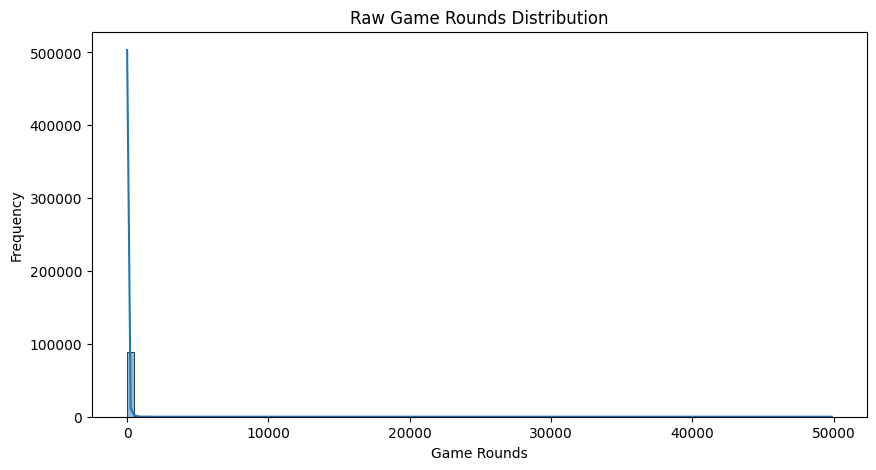

Maximum game rounds: 49854


In [76]:
# Visualize the raw distribution of sum_gamerounds
plt.figure(figsize=(10, 5))
sns.histplot(df['sum_gamerounds'], bins=100, kde=True)
plt.title('Raw Game Rounds Distribution')
plt.xlabel('Game Rounds')
plt.ylabel('Frequency')
plt.show()

# Check the maximum value to assess feasibility
max_rounds = df['sum_gamerounds'].max()
print(f'Maximum game rounds: {max_rounds}')

In [89]:
# Adjust outlier threshold to 99th percentile
top_99_threshold = df['sum_gamerounds'].quantile(0.99)
outliers_99 = df[df['sum_gamerounds'] > top_99_threshold]
print(f'Outliers in sum_gamerounds (> {top_99_threshold:.0f}) at 99th percentile')
print(f'Number of outliers: {len(outliers_99)}')

Outliers in sum_gamerounds (> 493) at 99th percentile
Number of outliers: 898


In [78]:
# Remove the top 1% of users (those with sum_gamerounds > 493)
df_99_percent = df[df['sum_gamerounds'] <= top_99_threshold]

- The distribution of `sum_gamerounds` is heavily right-skewed.
- Top 1% of players removed to reduce distortion.

### 3.2 Game Rounds Overview

In [79]:
# Descriptive statistics for the filtered dataset
print('Descriptive Statistics')
print(df_99_percent.groupby('version')[['sum_gamerounds', 'retention_1', 'retention_7']].describe())

Descriptive Statistics
        sum_gamerounds                                                       
                 count    mean     std    min    25%     50%     75%      max
version                                                                      
gate_30     44254.0000 44.6625 72.1206 0.0000 5.0000 16.0000 48.0000 493.0000
gate_40     45037.0000 44.3964 71.5397 0.0000 5.0000 16.0000 50.0000 493.0000


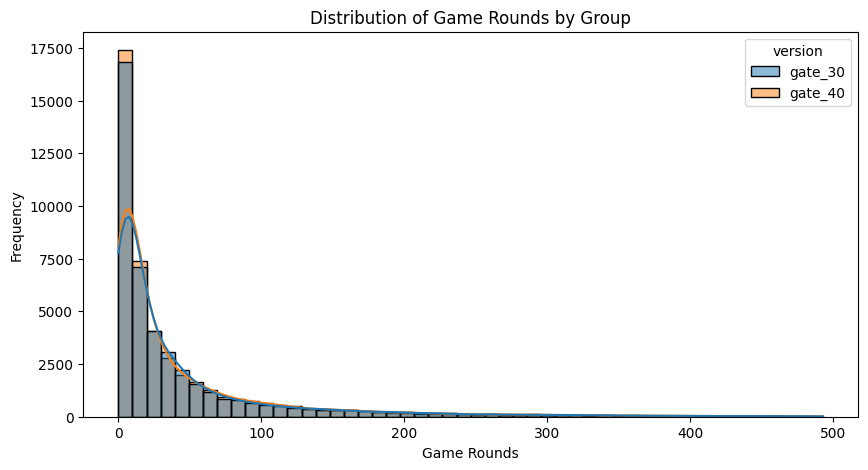

In [80]:
# Visualize distribution by group
plt.figure(figsize=(10, 5))
sns.histplot(data=df_99_percent, x='sum_gamerounds', hue='version', bins=50, kde=True)
plt.title('Distribution of Game Rounds by Group')
plt.xlabel('Game Rounds')
plt.ylabel('Frequency')
plt.savefig('game_rounds_distribution_filtered.png')
plt.show()

### 3.3 🔁 Retention Overview

In [81]:
# Descriptive statistics for retention
print('Descriptive Statistics for Retention')
print(df_99_percent.groupby('version')[['retention_1', 'retention_7']].mean() * 100)
print(df_99_percent.groupby('version')[['retention_1', 'retention_7']].describe())

Descriptive Statistics for Retention
         retention_1  retention_7
version                          
gate_30      44.2920      18.2537
gate_40      43.6907      17.4190
        retention_1                      retention_7                     
              count unique    top   freq       count unique    top   freq
version                                                                  
gate_30       44254      2  False  24653       44254      2  False  36176
gate_40       45037      2  False  25360       45037      2  False  37192


In [ ]:
# Visualization: Group by retention type
retention_rates = df_99_percent.groupby('version')[['retention_1', 'retention_7']].mean() * 100
retention_rates = retention_rates.reset_index().melt(id_vars='version',
                                                    value_vars=['retention_1', 'retention_7'],
                                                    var_name='Retention',
                                                    value_name='Rate')

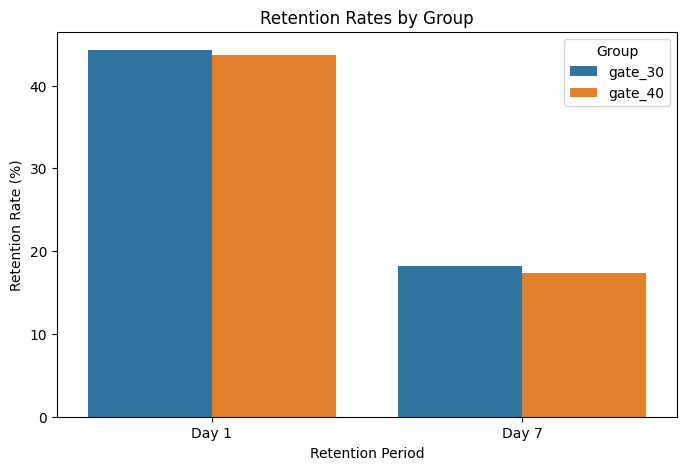

In [88]:
plt.figure(figsize=(8, 5))
sns.barplot(data=retention_rates, x='Retention', y='Rate', hue='version')
plt.title('Retention Rates by Group')
plt.xlabel('Retention Period')
plt.ylabel('Retention Rate (%)')
plt.xticks(ticks=[0, 1], labels=['Day 1', 'Day 7'])
plt.legend(title='Group')
plt.show()

- Day 1 retention is similar across groups.
- Day 7 retention is meaningfully lower for gate_40 users.
- Indicates potential longer-term churn caused by delayed gating.

## 4. Statistical Testing

### 4.1 Game Rounds – Mann-Whitney U Test

In [83]:
stat, p = mannwhitneyu(df_99_percent[df_99_percent['version'] == 'gate_30']['sum_gamerounds'],
                       df_99_percent[df_99_percent['version'] == 'gate_40']['sum_gamerounds'])
print('Mann-Whitney U Test for sum_gamerounds')
print(f'p-value = {p:.5f}')

Mann-Whitney U Test for sum_gamerounds
p-value = 0.04789


In [90]:
# Optimized Cliff's Delta with sampling
def cliffs_delta_sampled(x, y, sample_size=5000):
    np.random.seed(42)  # For reproducibility
    x_sample = np.random.choice(x, size=min(sample_size, len(x)), replace=False)
    y_sample = np.random.choice(y, size=min(sample_size, len(y)), replace=False)
    n1, n2 = len(x_sample), len(y_sample)
    comparisons = sum(1 if xi > yj else -1 if xi < yj else 0 for xi in x_sample for yj in y_sample)
    return comparisons / (n1 * n2)

delta = cliffs_delta_sampled(df_99_percent[df_99_percent['version'] == 'gate_30']['sum_gamerounds'],
                             df_99_percent[df_99_percent['version'] == 'gate_40']['sum_gamerounds'])
print('Cliff\'s Delta Effect Size for sum_gamerounds (Sampled)')
print(f'Cliff\'s Delta = {delta:.5f}')

Cliff's Delta Effect Size for sum_gamerounds (Sampled)
Cliff's Delta = 0.00561


- Non-normal distribution of `sum_gamerounds` --> Mann-Whitney U Test
- Result:  
  - p-value = 0.04789 → Statistically significant
  - Cliff’s Delta = 0.0056 → Negligible effect
- Conclusion:
While statistically significant, the difference in engagement is practically meaningless. Both versions perform similarly in terms of gameplay activity.

### 4.2 Retention – Chi-Square Tests

In [85]:
# Chi-Square tests
contingency_1 = pd.crosstab(df_99_percent['version'], df_99_percent['retention_1'])
contingency_7 = pd.crosstab(df_99_percent['version'], df_99_percent['retention_7'])

chi2, p_1, dof, expected = chi2_contingency(contingency_1)
print('Chi-Square Test for Day 1 Retention')
print(f'p-value = {p_1:.5f}')

chi2, p_7, dof, expected = chi2_contingency(contingency_7)
print('\nChi-Square Test for Day 7 Retention')
print(f'p-value = {p_7:.5f}')

Chi-Square Test for Day 1 Retention
p-value = 0.07137

Chi-Square Test for Day 7 Retention
p-value = 0.00116


In [86]:
# Retention rates and counts
rates_7 = df_99_percent.groupby('version')['retention_7'].mean()
counts_7 = df_99_percent.groupby('version')['retention_7'].sum()
nobs_7 = df_99_percent.groupby('version')['retention_7'].count()

# Confidence intervals for each group
ci_low_30, ci_high_30 = proportion_confint(counts_7['gate_30'], nobs_7['gate_30'], alpha=0.05, method='wilson')
ci_low_40, ci_high_40 = proportion_confint(counts_7['gate_40'], nobs_7['gate_40'], alpha=0.05, method='wilson')

# Difference in proportions and its CI
diff = rates_7['gate_30'] - rates_7['gate_40']
se_diff = np.sqrt(sum(rates_7 * (1 - rates_7) / nobs_7))
ci_diff = (diff - 1.96 * se_diff, diff + 1.96 * se_diff)

print('Day 7 Retention Analysis')
print(f'Gate_30: {rates_7["gate_30"]*100:.2f}% (95% CI: {ci_low_30*100:.2f}-{ci_high_30*100:.2f})')
print(f'Gate_40: {rates_7["gate_40"]*100:.2f}% (95% CI: {ci_low_40*100:.2f}-{ci_high_40*100:.2f})')
print(f'Difference: {diff*100:.2f}% (95% CI: {ci_diff[0]*100:.2f}-{ci_diff[1]*100:.2f})')

Day 7 Retention Analysis
Gate_30: 18.25% (95% CI: 17.90-18.62)
Gate_40: 17.42% (95% CI: 17.07-17.77)
Difference: 0.83% (95% CI: 0.33-1.34)


Day 1 Retention(p = 0.0714) → Not statistically significant

Day 7 Retention(p = 0.00116) → Statistically significant difference

## 5. Business Impact Assessment

In [87]:
# Estimate user impact
total_users = len(df_99_percent)
retained_30 = total_users * 0.1825
retained_40 = total_users * 0.1742
user_diff = retained_30 - retained_40

print('User Impact of Day 7 Retention Difference')
print(f'Total users: {total_users}')
print(f'Users retained (gate_30): {retained_30:.0f}')
print(f'Users retained (gate_40): {retained_40:.0f}')
print(f'Fewer users retained with gate_40: {user_diff:.0f}')

User Impact of Day 7 Retention Difference
Total users: 89291
Users retained (gate_30): 16296
Users retained (gate_40): 15554
Fewer users retained with gate_40: 741


### Key Findings
- **Engagement**

  Statistically significant (p = 0.04789), but negligible impact (Cliff’s Delta = 0.0056)

- **Retention**  
  Day 1: No significant difference
  
  Day 7: Significant drop with gate_40 (Δ = 0.83%, 95% CI: 0.33–1.34%)

- **Recommendation**

  Keep the gate at level 30
  Gate_40 reduces long-term retention, with a statistically significant 0.83% drop in Day 7 retention

  No meaningful improvement in engagement — gameplay activity is virtually unchanged
  
  Business impact is negative, with fewer retained users and potential LTV loss

###Next Steps

- **Test Intermediate Gate Levels**  
  Explore alternative placements (e.g., level 35 or 37) to identify a better balance between engagement and retention.

- **Measure Monetization Impact**  
  Track in-app purchase conversion and ARPU by gate level to assess true revenue implications beyond retention.

- **Segment-Level Analysis**  
  Evaluate retention and gameplay across user cohorts (e.g., country, device, install date) to identify groups that may benefit from gate_40.

- **Validate Experiment Design**  
  Check for sample balance and traffic integrity (randomization, SRM) to ensure test reliability.

- **Collect User Feedback**  
  Use in-app prompts or surveys to understand player experience and friction around gate timing.